<a href="https://colab.research.google.com/github/carlacodes/atchekegroup1lunarlanding/blob/Methyl/lunar_lander_original_pure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [ ]:
# # @title Install dependencies
# !sudo apt-get update > /dev/null 2>&1
# !sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install rarfile --quiet
# !pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
# !pip install box2d-py --quiet
# !pip install gym pyvirtualdisplay --quiet
# !pip install pyglet --quiet

[sudo] password for methyl: 
[sudo] password for methyl: 


In [ ]:
# Imports
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [ ]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

---
# Basic DQN Implementation


Now, let us set some hyperparameters for our algorithm. This is the only part you would play around with, to solve the first part of the project. 

In [ ]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.

Now, let us setup our model and the DQN algorithm. 

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v2')
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  #for simplicity, we are not doing batch update.
            buffer_size=1, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            gamma=0.99, #discount facto. range is between 0 and 1.
            tau = 1,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 1, #initial value of random action probability
            exploration_fraction = 0.5, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1, #number of gradient steps
            seed = 1, #seed for the pseudo random generators
            verbose=0) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

Before we train the model, let us look at an instance of Lunar Lander **before training**.  

**Note:** The following code for rendering the video is taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

In [ ]:
# test_env = wrap_env(gym.make("LunarLander-v2"))
# observation = test_env.reset()
# total_reward = 0
# while True:
#   test_env.render()
#   action, states = model.predict(observation, deterministic=True)
#   observation, reward, done, info = test_env.step(action)
#   total_reward += reward
#   if done:
#     break;

# # print(total_reward)
# test_env.close()
# show_video()

From the video above, we see that the lander has crashed! 
It is now the time for training! 


In [ ]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=-732.98 +/- 419.00
Episode length: 112.60 +/- 40.88
New best mean reward!
Eval num_timesteps=20000, episode_reward=18.63 +/- 119.73
Episode length: 94.80 +/- 46.21
New best mean reward!
Eval num_timesteps=30000, episode_reward=-55.05 +/- 41.02
Episode length: 63.40 +/- 2.80
Eval num_timesteps=40000, episode_reward=-162.74 +/- 47.16
Episode length: 72.80 +/- 12.25
Eval num_timesteps=50000, episode_reward=173.15 +/- 66.97
Episode length: 333.00 +/- 43.26
New best mean reward!
Eval num_timesteps=60000, episode_reward=-1.11 +/- 143.81
Episode length: 387.60 +/- 310.12
Eval num_timesteps=70000, episode_reward=163.01 +/- 93.13
Episode length: 496.60 +/- 19.77
Eval num_timesteps=80000, episode_reward=75.81 +/- 128.94
Episode length: 301.20 +/- 57.42
Eval num_timesteps=90000, episode_reward=250.64 +/- 34.42
Episode length: 280.00 +/- 10.43
New best mean reward!
Eval num_timesteps=100000, episode_reward=184.23 +/- 17.56
Episode length: 695.40 +/- 30.15


In [ ]:
# env = wrap_env(gym.make("LunarLander-v2"))
# observation = env.reset()
# while True:
#   env.render()
#   action, _states = model.predict(observation, deterministic=True)
#   observation, reward, done, info = env.step(action)
#   if done:
#     break;

# env.close()
# show_video()

Text(0, 0.5, 'Episode Rewards')

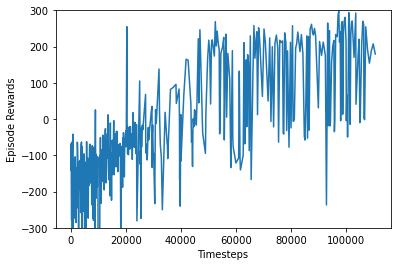

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')